In [6]:
from pathlib import Path
path_to_data_notebook = Path.cwd().parent.parent.parent / "Data" / "1_Preprocesed_data.ipynb"
%run {path_to_data_notebook}

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import datetime 
import time
from sklearn.model_selection import train_test_split

2025-03-19 22:53:00.071775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742421180.090598  176468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742421180.096235  176468 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 22:53:00.115209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
size = 35
x_range_to_cut = 0.001
df = get_whole_preprocessed_dataframe(size, x_range_to_cut)
# choosen property for y:
choosen_property_1 = "Total_surface_area[m2/g]"

df_with_data = df[df[choosen_property_1].notna()]    # get data if property are present
df_without_data = df[df[choosen_property_1].isna()]    # get data if property arent present

X = df_with_data['processed_flatten_isotherm_X_Y'] # x = 'processed_flatten_isotherm_X_Y'
y = df_with_data # y - temporary all columns for prediction inspection, in next steps we extract only choosen property

X_train, X_test, y_train_nested, y_test_nested, = train_test_split(X, y, test_size=0.02, random_state=42) #random_state=42

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train_nested[choosen_property_1].to_numpy()
y_test = y_test_nested[choosen_property_1].to_numpy() 


scaler = StandardScaler() # only for x data
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

print(f'X_train size = {len(X_train)}')
print(f'y_train size = {len(X_train)}')
print(f'X_test size = {len(X_test)}')
print(f'y_test size = {len(X_test)}')

/home/pc/moje/python_projects/adsorbents_isotherms/Data/all_data.csv
------------------------------- Preprocessing_data start -------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Article_name                    1011 non-null   object 
 1   Figure_number                   1011 non-null   object 
 2   Sample_name                     1011 non-null   object 
 3   Total_surface_area[m2/g]        928 non-null    float64
 4   Total_pore_volume[cm3/g]        778 non-null    float64
 5   Micropore_volume[cm3/g]         730 non-null    float64
 6   Mesopore_volume[cm3/g]          21 non-null     float64
 7   Average_pore_diameter[nm]       121 non-null    float64
 8   Impregnation_ratio[agent/char]  20 non-null     float64
 9   Activation_type                 33 non-null     object 
 10

In [8]:
X_without = df_without_data['processed_flatten_isotherm_X_Y'].tolist()
X_without = scaler.transform(X_without) 
y_without = df_without_data[choosen_property_1].to_numpy()
print(f'X_without size = {len(X_without)}')
print(f'y_without size = {len(y_without)}')

X_without size = 83
y_without size = 83


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
def calculate_time(transcription_time):
    timedelta_obj = datetime.timedelta(seconds=int(transcription_time))
    return str(timedelta_obj)

In [12]:
epochs_number = 500

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(size, activation='relu'), 
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)                      
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=['mae', 'mse']
model.compile(optimizer=optimizer, loss='mae', metrics=metrics)



# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# history  =  model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)
start = time.time()
history  =  model.fit(X_train, y_train, epochs=epochs_number, batch_size=32, validation_split=0.1, verbose=2)
end = time.time()
transcription_time = calculate_time(round((end - start),2))
print(f"Model training time: "+transcription_time)
model.summary()
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")




Epoch 1/500


I0000 00:00:1742421186.692363  176468 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9780 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:09:00.0, compute capability: 7.5
I0000 00:00:1742421187.814260  176528 service.cc:148] XLA service 0x7a330001c100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742421187.814296  176528 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-19 22:53:07.839632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742421187.957793  176528 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742421188.494001  176528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 - 3s - 106ms/step - loss: 1050.6531 - mae: 1050.6531 - mse: 1551518.2500 - val_loss: 1058.0419 - val_mae: 1058.0419 - val_mse: 1644680.0000
Epoch 2/500
25/25 - 0s - 4ms/step - loss: 1011.7894 - mae: 1011.7894 - mse: 1452009.6250 - val_loss: 963.6243 - val_mae: 963.6243 - val_mse: 1394878.0000
Epoch 3/500
25/25 - 0s - 4ms/step - loss: 826.8933 - mae: 826.8933 - mse: 1001766.6875 - val_loss: 595.9614 - val_mae: 595.9614 - val_mse: 550413.8125
Epoch 4/500
25/25 - 0s - 4ms/step - loss: 466.4947 - mae: 466.4947 - mse: 327653.9688 - val_loss: 379.9873 - val_mae: 379.9873 - val_mse: 265336.5000
Epoch 5/500
25/25 - 0s - 4ms/step - loss: 361.2963 - mae: 361.2963 - mse: 203060.3906 - val_loss: 317.3484 - val_mae: 317.3484 - val_mse: 166480.4375
Epoch 6/500
25/25 - 0s - 4ms/step - loss: 343.8249 - mae: 343.8249 - mse: 186795.4062 - val_loss: 301.9833 - val_mae: 301.9833 - val_mse: 155407.1562
Epoch 7/500
25/25 - 0s - 3ms/step - loss: 325.9925 - mae: 325.9925 - mse: 167669.8594 - val_loss: 2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 140)            │         5,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         7,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,880 (171.41 KB)

 Trainable params: 14,626 (57.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,254 (114.28 KB)

Metrics: [64.29073333740234, 64.29073333740234, 5754.63525390625]
mae = 64.29073333740234
mse = 5754.63525390625


Model training time without gpu, epoch = 1000 : 0:01:10


ALL:
 przewidywana --> [921.3797]     1041.9 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [439.41388]     378.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [745.89233]     770.1 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1389.339]     1343.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [599.79803]     659.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [776.3266]     817.2 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1353.6625]     1387.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1957.6586]     2064.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [473.38864]     448.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1800.5452]     1784.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 p

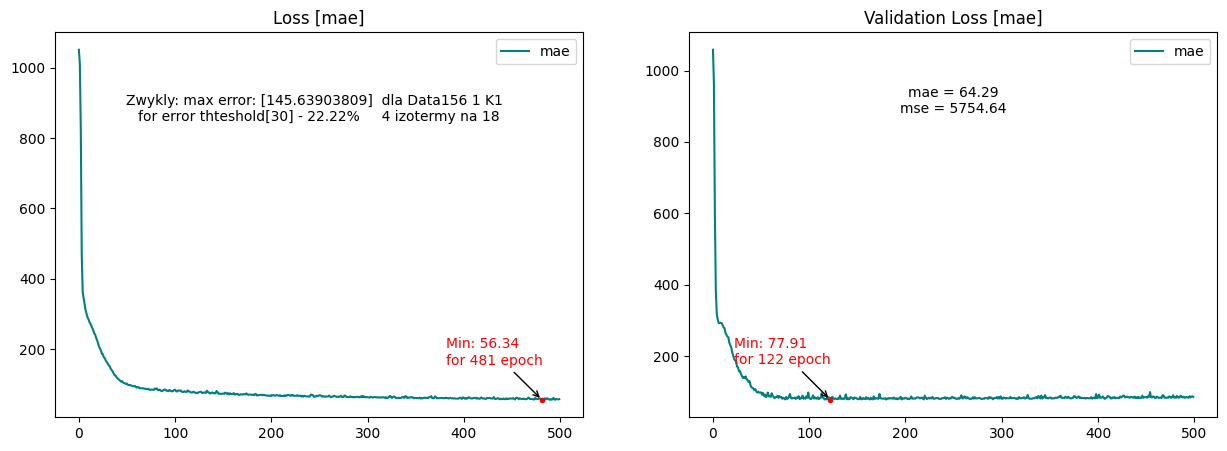

In [66]:
error_threshold = 30
max_error_threshold = 30
predictions = model.predict(X_test, verbose=0)
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    data_name = y_test_nested.iloc[i,0]
    graph_number = y_test_nested.iloc[i,1]
    sample_name = y_test_nested.iloc[i,2]
    error = abs(predictions[i] - y_test[i])
    
    errors.append(error)
    if(error_threshold<=error):
        list_above.append(i)
    else: list_below.append(i)

    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {error}   {data_name} {graph_number} {sample_name}")

max_error_index = errors.index(max(errors))
max_error_data_name = y_test_nested.iloc[max_error_index,0]
max_error_graph_number = y_test_nested.iloc[max_error_index,1]
max_error_sample_name = y_test_nested.iloc[max_error_index,2]
text_to_display = f"Zwykly: max error: {max(errors)}  dla {max_error_data_name} {max_error_graph_number} {max_error_sample_name}  "  + "\n" + f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}"




results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
metrics_text = ""
for index, metric in enumerate(metrics):
    metrics_text = metrics_text + f"{metric} = {results[index+1]:.2f}" + "\n"
    print(f"{metric} = {results[index+1]}")

from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

min_loss_idx = history.history['loss'].index(min(history.history['loss']))
min_loss = min(history.history['loss'])# Get the lowest  value
ax[0].plot(history.history['loss'], color='teal', label='mae')
# ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss [mae]')
ax[0].legend()
ax[0].annotate(f'Min: {min_loss:.2f} \nfor {min_loss_idx} epoch', 
               xy=(min_loss_idx, min_loss), 
               xytext=(min_loss_idx - 100, min_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[0].plot(min_loss_idx, min_loss, 'ro',markersize=3)# Plot a dot at the minimum point
ax[0].text(0.5, 0.8, text_to_display, horizontalalignment='center', verticalalignment='center',fontsize=10, transform=ax[0].transAxes)

min_val_loss_idx = history.history['val_loss'].index(min(history.history['val_loss']))# Find the index of the minimum 
min_val_loss = min(history.history['val_loss'])# Get the lowest  value
ax[1].plot(history.history['val_loss'], color='teal', label='mae')
# ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Validation Loss [mae]')
ax[1].legend()
# Annotate the lowest point on the validation loss curve
ax[1].annotate(f'Min: {min_val_loss:.2f} \nfor {min_val_loss_idx} epoch', 
               xy=(min_val_loss_idx, min_val_loss), 
               xytext=(min_val_loss_idx - 100, min_val_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[1].plot(min_val_loss_idx, min_val_loss, 'ro', markersize=3)# Plot a dot at the minimum point
ax[1].text(0.5, 0.8, metrics_text, horizontalalignment='center', verticalalignment='center',fontsize=10, transform=ax[1].transAxes)
# ax[2].plot(history.history['val_mse'], color='teal', label='regress loss')
# # ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# ax[2].title.set_text('Validation mse')
# ax[2].legend()

plt.show()

# fig.savefig('zwykle_v1.jpg', dpi=100)

In [34]:
error_threshold = 30
max_error_threshold = 30
predictions = model.predict(X_test, verbose=0)
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    data_name = y_test_nested.iloc[i,0]
    graph_number = y_test_nested.iloc[i,1]
    sample_name = y_test_nested.iloc[i,2]
    error = abs(predictions[i] - y_test[i])
    
    errors.append(error)
    if(error_threshold<=error):
        list_above.append(i)
    else: list_below.append(i)

print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {error}   {data_name} {graph_number} {sample_name}")
max_error_index = errors.index(max(errors))
max_error_data_name = y_test_nested.iloc[max_error_index,0]
max_error_graph_number = y_test_nested.iloc[max_error_index,1]
max_error_sample_name = y_test_nested.iloc[max_error_index,2]
print(f"max error: {max(errors)}  dla {max_error_data_name} {max_error_graph_number} {max_error_sample_name}  " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")


ALL:
 przewidywana --> [921.3797]     1041.9 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [439.41388]     378.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [745.89233]     770.1 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1389.339]     1343.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [599.79803]     659.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [776.3266]     817.2 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1353.6625]     1387.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1957.6586]     2064.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [473.38864]     448.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 przewidywana --> [1800.5452]     1784.0 <-- rzeczyswista     blad: [101.646698]   Data119 6 Xp0.50
 p

# scaler

In [13]:
error_threshold = 30
max_error_threshold = 30
predictions = model.predict(X_test, verbose=0)
predictions = output_scaler.inverse_transform(predictions)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)
y_test = output_scaler.inverse_transform(y_test)
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    errors.append(abs(predictions[i] - y_test[i]))
    # print(f"{i} {predictions[i]}  ------   {y_valid[i]}           blad: {abs(predictions[i] - y_valid[i])}")
    # if(abs(predictions[i] - y_test[i]) > max_error_threshold):
    #     print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        
    if(error_threshold<=abs(predictions[i] - y_test[i])):
        list_above.append(i)
    else: list_below.append(i)

print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}   {y_test_nested.iloc[i,0]} {y_test_nested.iloc[i,1]} {y_test_nested.iloc[i,2]}")

print(f"max error: {max(errors)}  dla {y_test_nested.iloc[errors.index(max(errors)),0]} {y_test_nested.iloc[errors.index(max(errors)),1]} {y_test_nested.iloc[errors.index(max(errors)),2]}  " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")


ALL:
 przewidywana --> [955.6867]     [1041.9] <-- rzeczyswista     blad: [86.21329346]   Data58 5_4 850-45m
 przewidywana --> [481.1255]     [378.] <-- rzeczyswista     blad: [103.12548828]   Data115 1 CAC1900
 przewidywana --> [775.2813]     [770.1] <-- rzeczyswista     blad: [5.18131104]   Data58 5_3 800-1h
 przewidywana --> [1433.7211]     [1343.] <-- rzeczyswista     blad: [90.72106934]   Data150 4 10stC
 przewidywana --> [599.39343]     [659.] <-- rzeczyswista     blad: [59.60656738]   Data7 3 RK-600
 przewidywana --> [771.859]     [817.2] <-- rzeczyswista     blad: [45.34099121]   Data58 5_3 800-1h15m
 przewidywana --> [1326.1232]     [1387.] <-- rzeczyswista     blad: [60.87683105]   Data65 2_2 R2-500
 przewidywana --> [2161.0364]     [2064.] <-- rzeczyswista     blad: [97.03637695]   Data59 2 CMS500
 przewidywana --> [434.49414]     [448.] <-- rzeczyswista     blad: [13.50585938]   Data43 6 F1-8-11
 przewidywana --> [1782.0216]     [1784.] <-- rzeczyswista     blad: [1.978393

- skaler: 
    max error: [104.72827148]  dla Data156 1 K1  
    for error thteshold[30] - 33.33%     6 izotermy na 18

- log:
    max error: [185.28442383]  dla Data79 2 0.25-C  
    for error thteshold[30] - 100.0%     18 izotermy na 18
- zwykly:
max error: [246.68322754]  dla Data156 1 K1  
for error thteshold[30] - 22.22%     4 izotermy na 18


In [75]:
predictions_for_data_without = model.predict(X_without, verbose=0)
for i in range(len(predictions_for_data_without)):
    print(f'{predictions_for_data_without[i][0]:.2f}    <---->  {y_without[i]:.2f}   ')

-0.14    <---->  nan   
-0.77    <---->  nan   
-1.57    <---->  nan   
-1.50    <---->  nan   
-1.48    <---->  nan   
-1.44    <---->  nan   
-1.47    <---->  nan   
-0.88    <---->  nan   
0.26    <---->  nan   
0.20    <---->  nan   
1.38    <---->  nan   
-0.54    <---->  nan   
0.21    <---->  nan   
1.09    <---->  nan   
0.03    <---->  nan   
1.04    <---->  nan   
0.57    <---->  nan   
-0.39    <---->  nan   
-0.16    <---->  nan   
-0.96    <---->  nan   
-0.26    <---->  nan   
1.66    <---->  nan   
-0.87    <---->  nan   
-0.29    <---->  nan   
-0.23    <---->  nan   
0.03    <---->  nan   
0.01    <---->  nan   
-0.24    <---->  nan   
0.10    <---->  nan   
0.12    <---->  nan   
2.74    <---->  nan   
2.21    <---->  nan   
1.82    <---->  nan   
0.96    <---->  nan   
-0.50    <---->  nan   
0.17    <---->  nan   
1.15    <---->  nan   
1.16    <---->  nan   
-0.87    <---->  nan   
-0.65    <---->  nan   
0.07    <---->  nan   
0.55    <---->  nan   
1.93    <---->

In [45]:
#model.save("saved_models/model_s35_500_mae3400_maxerr-121_warstwy-35-160-50.keras")


In [46]:
from tensorflow.keras.models import load_model
model_name = 'saved_models/model_s35_500_mae34_maxerr-121_warstwy-35-160-50.keras'
modelos = load_model(model_name)
predictions = modelos.predict(X_test, verbose=0)
print(f"len {len(X_test)}")
error_threshold = 30
max_error_threshold = 30
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    errors.append(abs(predictions[i] - y_test[i]))
    # print(f"{i} {predictions[i]}  ------   {y_valid[i]}           blad: {abs(predictions[i] - y_valid[i])}")
    # if(abs(predictions[i] - y_test[i]) > max_error_threshold):
    #     print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        
    if(error_threshold<=abs(predictions[i] - y_test[i])):
        list_above.append(i)
    else: list_below.append(i)
print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        


print(f"max error: {max(errors)}  dla {y_test_nested[errors.index(max(errors))][1]} " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")

len 18

ALL:
 przewidywana --> [971.2737]     1041.9 <-- rzeczyswista     blad: [70.62631836]  ['Data58', '850-45m', '5_4', 'II']
 przewidywana --> [395.97638]     378.0 <-- rzeczyswista     blad: [17.97637939]  ['Data115', 'CAC1900', '1', 'I']
 przewidywana --> [742.24585]     770.1 <-- rzeczyswista     blad: [27.85415039]  ['Data58', '800-1h', '5_3', 'II']
 przewidywana --> [1362.1091]     1343.0 <-- rzeczyswista     blad: [19.10913086]  ['Data150', '10stC', '4', 'I_II']
 przewidywana --> [590.9509]     659.0 <-- rzeczyswista     blad: [68.04907227]  ['Data7', 'RK-600', '3', 'I']
 przewidywana --> [776.3707]     817.2 <-- rzeczyswista     blad: [40.82927246]  ['Data58', '800-1h15m', '5_3', 'II']
 przewidywana --> [1479.6089]     1387.0 <-- rzeczyswista     blad: [92.60888672]  ['Data65', 'R2-500', '2_2', 'I_IV']
 przewidywana --> [2005.0792]     2064.0 <-- rzeczyswista     blad: [58.92077637]  ['Data59', 'CMS500', '2', 'I_II']
 przewidywana --> [457.05875]     448.0 <-- rzeczyswista 

In [ ]:
#  przewidywana --> [553.189]     249.0 <-- rzeczyswista     blad: [304.18903]  ['Data125', 'coconut_shells_6h', '7']
#  przewidywana --> [1967.7969]     1616.22 <-- rzeczyswista     blad: [351.5769]  ['Data153', 'GC-C04', '4']
#  przewidywana --> [1556.715]     1193.2 <-- rzeczyswista     blad: [363.515]  ['Data54', 'CZ0.65', '3']
#  przewidywana --> [1296.133]     938.0 <-- rzeczyswista     blad: [358.13306]  ['Data15', '3', '1']
#  przewidywana --> [732.7655]     1188.0 <-- rzeczyswista     blad: [455.2345]  ['Data156', 'MCAC-2-1', '4']
#  przewidywana --> [573.38586]     976.0 <-- rzeczyswista     blad: [402.61414]  ['Data47', 'ACF30M-HNO3', '3']
#  przewidywana --> [350.85513]     823.0 <-- rzeczyswista     blad: [472.14487]  ['Data86', 'ACZ3', '2']
# max error: [472.14487]  dla ['Data86', 'ACZ3', '2'] 
# for error thteshold[50] - 57.8%     100 izotermy na 173